# Assignment - 7- B
## Image similarity estimation using a Siamese Network with a triplet loss

## Introduction

A [Siamese Network](https://en.wikipedia.org/wiki/Siamese_neural_network) is a type of network architecture that
contains two or more identical subnetworks used to generate feature vectors for each input and compare them.

Siamese Networks can be applied to different use cases, like detecting duplicates, finding anomalies, and face recognition.

This example uses a Siamese Network with three identical subnetworks. We will provide three images to the model, where
two of them will be similar (_anchor_ and _positive_ samples), and the third will be unrelated (a _negative_ example.)
Our goal is for the model to learn to estimate the similarity between images.

For the network to learn, we use a triplet loss function. You can find an introduction to triplet loss in the
[FaceNet paper](https://arxiv.org/pdf/1503.03832.pdf) by Schroff et al,. 2015. In this example, we define the triplet
loss function as follows:

`L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)`

## Tasks
1. Fetch the data using the following code and create tripets using the helper code. Visualize few random triplets
2. Write a code to preprocess the images. Standard preprocessing includes decoding the image, convert the dtype to float and resizing the image. Use tensorflow functions to do so and store your data in tensorflow variables rather than numpy or python lists as it is much faster.
3. Shuffle the dataset, Split into train and validation. (80-20)
4. Use a pretrained ResNet50 to obtain embeddings for images (freeze the weights). Add few Dense and Batch Norm layers at the end.  Implement triplet loss and train the model. Keep a track of val loss.
5. Now unfreeze last few layers of ResNet50 and rerun the experiment. Compare the val loss of this model with val loss of previous model(with parameters freezed).
6. Use cosine cosine similarity metric to measure how to 2 output embeddings are similar to each other. Is similiarty of  (Anchor , Positive ) > (Anchor , Negative)


## Note -

Change the runtime type to T4 GPU on your colab. Without GPU, the model takes much longer.

## Dataset
* Original Dataset - https://vis-www.cs.umass.edu/lfw/
* Fewer examples from this dataset suitable for our task is selected and is hosted in the following link.

In [1]:
!gdown 1ykjp7xHOE2TSTjcDzm6NlJRP2n_JSaBW

/bin/bash: line 1: gdown: command not found


In [2]:
!unzip /content/LFW_Trimmed_zip.zip

/bin/bash: line 1: unzip: command not found


In [3]:
image_dir = "/content/LFW_Trimmed"

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from pathlib import Path
import pandas as pd

In [5]:
filename = image_dir+"/Aaron_Peirsol/Aaron_Peirsol_0001.jpg"
pixels = plt.imread(filename)

# Show RGB shape
rgb_pixels = np.stack((pixels, pixels, pixels), axis=2)
print(rgb_pixels.shape)

# Show example image
plt.imshow(pixels)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/content/LFW_Trimmed/Aaron_Peirsol/Aaron_Peirsol_0001.jpg'

(250, 250, 3, 3)


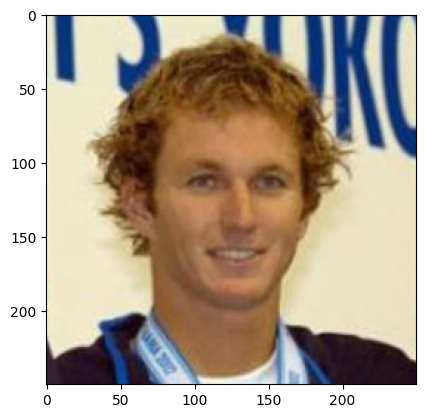

In [ ]:
filename = image_dir+"/Aaron_Peirsol/Aaron_Peirsol_0002.jpg"
pixels = plt.imread(filename)

# Show RGB shape
rgb_pixels = np.stack((pixels, pixels, pixels), axis=2)
print(rgb_pixels.shape)

# Show example image
plt.imshow(pixels)
plt.show()

In [ ]:
subjects= os.listdir(image_dir)   # list of all people
image_paths = []
for subject in subjects:
    subject_path = os.path.join(image_dir, subject)
    for filename in os.listdir(subject_path):
        full_path = os.path.join(subject_path, filename)
        image_paths.append(full_path)    # storing path for each and every image in image paths


#photos_list_flatten = [item for sublist in photos_list for item in sublist]
print(len(subjects))
print(subjects[:5])
print(image_paths[:2])

100
['Alan_Greenspan', 'James_Kopp', 'Martha_Stewart', 'Ben_Affleck', 'Geoff_Hoon']
['/content/LFW_Trimmed/Alan_Greenspan/Alan_Greenspan_0005.jpg', '/content/LFW_Trimmed/Alan_Greenspan/Alan_Greenspan_0001.jpg']


In [ ]:
from itertools import combinations  # imported to create combinations

In [ ]:
def create_triplets(subjects, photos_list):    # two images of same person and one image of another person
  anchor_positive=[]
  negative=[]
  for subject in subjects:
    subject_photos= [i for i in photos_list if subject in i]
    non_subjectphotos= [i for i in photos_list if subject not in i]
    anchor_positiveset= list(combinations(subject_photos, 2))
    anchor_positive.extend(anchor_positiveset)
    negative.extend(random.choices(non_subjectphotos, k=len(anchor_positiveset)))
  data_df=pd.DataFrame(anchor_positive,columns=['anchor','positive'])
  data_df['negative']=negative
  return data_df


In [ ]:
data_df=create_triplets(subjects,image_paths)  # each column represents anchor, postive and negative image
print(data_df.shape)

(1003, 3)


# Work

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf

from pathlib import Path
from keras import applications
from keras import layers
from keras import losses
from keras import ops
from keras import optimizers
from keras import metrics
from keras import Model

from keras.applications import resnet

import gdown
import unzip


target_shape = (200, 200)

In [5]:
cache_dir = Path(Path.home()) / ".keras"
anchor_images_path = cache_dir / "left"
positive_images_path = cache_dir / "right"

In [6]:
!gdown —id 1jvkbTr_giSP3Ru8OwGNCg6B4PvVbcO34
!gdown —id 1EzBZUb_mh_Dp_FKD0P4XiYYSd0QBH5zW

!unzip -oq left.zip -d $cache_dir

!unzip -oq right.zip -d $cache_dir

usage: gdown [-h] [-V] [-O OUTPUT] [-q] [--fuzzy] [--id] [--proxy PROXY]
             [--speed SPEED] [--no-cookies] [--no-check-certificate]
             [--continue] [--folder] [--remaining-ok] [--format FORMAT]
             url_or_id
gdown: error: unrecognized arguments: 1jvkbTr_giSP3Ru8OwGNCg6B4PvVbcO34
usage: gdown [-h] [-V] [-O OUTPUT] [-q] [--fuzzy] [--id] [--proxy PROXY]
             [--speed SPEED] [--no-cookies] [--no-check-certificate]
             [--continue] [--folder] [--remaining-ok] [--format FORMAT]
             url_or_id
gdown: error: unrecognized arguments: 1EzBZUb_mh_Dp_FKD0P4XiYYSd0QBH5zW
unzip:  cannot find or open left.zip, left.zip.zip or left.zip.ZIP.
unzip:  cannot find or open right.zip, right.zip.zip or right.zip.ZIP.


In [27]:
# experiment

import os
import zipfile
from pathlib import Path
from urllib.request import urlopen
from io import BytesIO

# Set the URL for the Totally Looks Like dataset
url = "https://github.com/richzhang/totallylookslike/releases/download/v0.1/tll-small.zip"

# Define the local directory for extraction
local_dir = Path("~/.keras/tll_dataset").expanduser()

# Create the local directory if it doesn't exist
local_dir.mkdir(parents=True, exist_ok=True)

# Download the zip file
response = urlopen(url)
zip_data = BytesIO(response.read())

# Unzip the file
with zipfile.ZipFile(zip_data, 'r') as zip_ref:
    zip_ref.extractall(local_dir)

# Display the list of files in the extracted directory
extracted_files = os.listdir(local_dir)
extracted_files


HTTPError: HTTP Error 404: Not Found